In [1]:
# !pip install -q --upgrade git+https://github.com/matthias-wright/flaxmodels.git

In [2]:
import clearml
from clearml import Task

clearml.browser_login()

In [3]:
hparams = {
    "archi": "cnn",
    "batch_size": 128,
    "lr": 0.001,
    "optimizer": "adam"
}

task = Task.init(
    project_name="jax-examples",
    task_name="cnn-cifar10",
    output_uri=True
)

task.connect(hparams)

ClearML Task: created new task id=b73fde530b104da6a30b8bab226cb1f5
2024-02-02 13:42:42,109 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/8e5be1efcfdc487e86bb77cd5a52222f/experiments/b73fde530b104da6a30b8bab226cb1f5/output/log


{'archi': 'cnn', 'batch_size': 128, 'lr': 0.001, 'optimizer': 'adam'}

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
import jax
import jax.numpy as jnp

In [6]:
import matplotlib.pyplot as plt
import numpy as np


In [7]:
import flax
import flax.linen as nn

In [8]:
import torch

In [9]:
"""
dummy_input = np.random.normal(256, 256, 3)
h_in, w_in, c_in = dummy_input.shape

kernel_size = (5, 5)
dilation = (1, 1)
stride = (1, 1)
padding = (0, 0)


h_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]
h_out += 1

w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]
w_out += 1


print(h_out)
print(w_out)


conv1 = nn.Conv(features=1, kernel_size=kernel_size, padding=padding, strides=stride)
out, vars = conv1.init_with_output(jax.random.key(0), dummy_input)

out.shape

pooled1 = nn.max_pool(out, window_shape=(2, 2))
pooled1.shape


conv2 = nn.Conv(features=1, kernel_size=kernel_size, padding=padding, strides=stride)
out2, vars = conv1.init_with_output(jax.random.key(0), out)

out2.shape

pooled2 = nn.max_pool(out2, window_shape=(2, 2))
pooled2.shape

"""

'\ndummy_input = np.random.normal(256, 256, 3)\nh_in, w_in, c_in = dummy_input.shape\n\nkernel_size = (5, 5)\ndilation = (1, 1)\nstride = (1, 1)\npadding = (0, 0)\n\n\nh_out = (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]\nh_out += 1\n\nw_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]\nw_out += 1\n\n\nprint(h_out)\nprint(w_out)\n\n\nconv1 = nn.Conv(features=1, kernel_size=kernel_size, padding=padding, strides=stride)\nout, vars = conv1.init_with_output(jax.random.key(0), dummy_input)\n\nout.shape\n\npooled1 = nn.max_pool(out, window_shape=(2, 2))\npooled1.shape\n\n\nconv2 = nn.Conv(features=1, kernel_size=kernel_size, padding=padding, strides=stride)\nout2, vars = conv1.init_with_output(jax.random.key(0), out)\n\nout2.shape\n\npooled2 = nn.max_pool(out2, window_shape=(2, 2))\npooled2.shape\n\n'

In [10]:
import jax_dataloader as jdl
import torchvision
import torchvision.transforms as transforms

class ToNumpy:
    def __call__(self, x: torch.Tensor):
        return x.numpy()


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ToNumpy()])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = jdl.DataLoader(trainset, backend="pytorch", batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = jdl.DataLoader(testset, backend="pytorch", batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#print(trainset[0])

/home/shawon/Projects/jax_examples/venv/lib64/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.



Files already downloaded and verified
Files already downloaded and verified


In [11]:
from einops import rearrange

class ConvNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        # convs
        out = nn.Conv(features=6, kernel_size=(5, 5))(x)
        out = nn.max_pool(out, window_shape=(2, 2))
        out = nn.Conv(features=16, kernel_size=(5, 5))(out)
        out = nn.max_pool(out, window_shape=(2, 2))


        # flatten into a vector 
        # skip the batch dim
        if len(x.shape) > 3:
            out = rearrange(x, "batch c h w -> batch (c h w)")
        else:
            out = out.flatten()

        # dense
        out = nn.Dense(features=120)(out)
        out = nn.Dense(features=84)(out)
        out = nn.Dense(features=10)(out)

        return out


model = ConvNet()
params = model.init(jax.random.key(0), trainset[0][0])

logits = model.apply(params, trainset[0][0])
logits.shape

(10,)

In [12]:
import optax

@jax.jit
def calculate_loss(params, x, y):
    logits = model.apply(params, x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y)
    return loss

@jax.jit
def batched_loss(params, xs, ys):
    batch_loss = jax.vmap(calculate_loss, in_axes=(None, 0, 0))(params, xs, ys)
    return batch_loss.mean(axis=-1)


calculate_loss(params, trainset[0][0], trainset[0][1])

Array(2.4910936, dtype=float32)

In [13]:
for batch in trainloader:
    print(batch[0].shape)
    l = batched_loss(params, *batch)
    print(l)
    break

(128, 3, 32, 32)
2.3323336


In [14]:
from tqdm.auto import trange, tqdm
from flax.training import train_state
from functools import partial


optimiser = optax.adam(learning_rate=0.001)
state = train_state.TrainState.create(
    apply_fn=model.apply, # the forward function
    params=params,
    tx=optimiser
)
criterion = jax.value_and_grad(batched_loss)



In [15]:
from sklearn.metrics import f1_score

@jax.jit
def train_step(state, batch):
    loss_value, grads = criterion(state.params, *batch)
    updated_state = state.apply_gradients(grads=grads)
    return loss_value, updated_state


@jax.jit
def test_step(state, xs):
    def infer(params, x):
        logits = model.apply(params, x)
        return jax.nn.softmax(logits, axis=-1) 

    preds = jax.vmap(jax.jit(infer), in_axes=(None, 0))(state.params, xs)
    return preds
        

In [16]:
def evaluate(state, test_loader):
    scores = list()
    for batch in tqdm(test_loader):
        xs, ys = batch
        preds = test_step(state, xs)
        preds = jnp.argmax(preds, axis=-1)
        f1 = f1_score(preds, ys, average="micro")
        scores.append(f1)

    return np.array(scores).mean(axis=-1)



evaluate(state, testloader)

  0%|          | 0/79 [00:00<?, ?it/s]

0.10808939873417721

In [17]:
from tqdm.auto import trange

steps = 0
train_losses = []
test_f1 = []

for e in trange(5):
    for batch in tqdm(trainloader):
        loss, state = train_step(state, batch)
        steps += 1

        if steps % 200 == 0:
            train_losses.append(loss)
            task.logger.report_scalar(title="loss/train", series="loss", value=loss, iteration=steps)
            
            # run evaluation
            print("Evaluating ... ")
            score = evaluate(state, testloader)
            task.logger.report_scalar(title="f1/test", series="f1", value=score, iteration=steps)
            test_f1.append(score)

            print(f"Epoch : {e + 1} :: Step : {steps} :: Loss : {loss}  :: F1 : {score}")
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 1 :: Step : 200 :: Loss : 1.558483362197876  :: F1 : 0.4396756329113924


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 2 :: Step : 400 :: Loss : 1.4810092449188232  :: F1 : 0.4622231012658228
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 2 :: Step : 600 :: Loss : 1.4202005863189697  :: F1 : 0.4783425632911392


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 3 :: Step : 800 :: Loss : 1.5418181419372559  :: F1 : 0.4873417721518987
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 3 :: Step : 1000 :: Loss : 1.3909101486206055  :: F1 : 0.5007911392405063


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 4 :: Step : 1200 :: Loss : 1.2390213012695312  :: F1 : 0.5036590189873418
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 4 :: Step : 1400 :: Loss : 1.4388818740844727  :: F1 : 0.5170094936708861


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 5 :: Step : 1600 :: Loss : 1.3556393384933472  :: F1 : 0.5134493670886076
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 5 :: Step : 1800 :: Loss : 1.4368547201156616  :: F1 : 0.5110759493670886


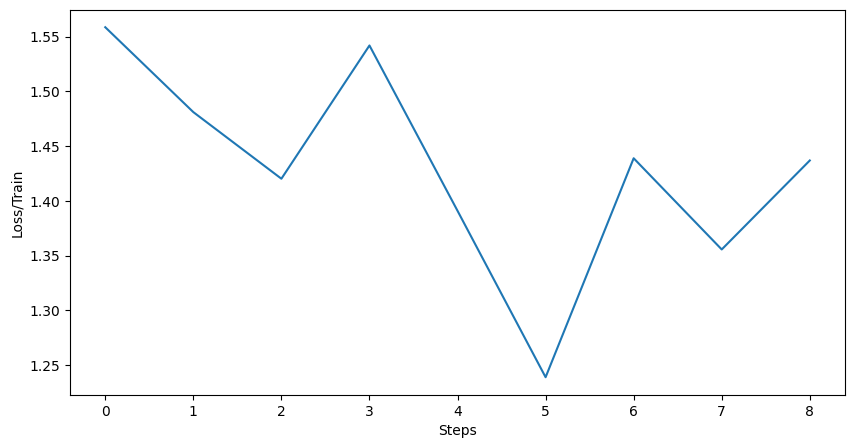

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
fig.add_subplot()
plt.xlabel("Steps")
plt.ylabel("Loss/Train")
plt.plot(np.arange(len(train_losses)), train_losses) 

task.logger.report_matplotlib_figure(title="Train Loss / Steps",figure=fig, series="loss")


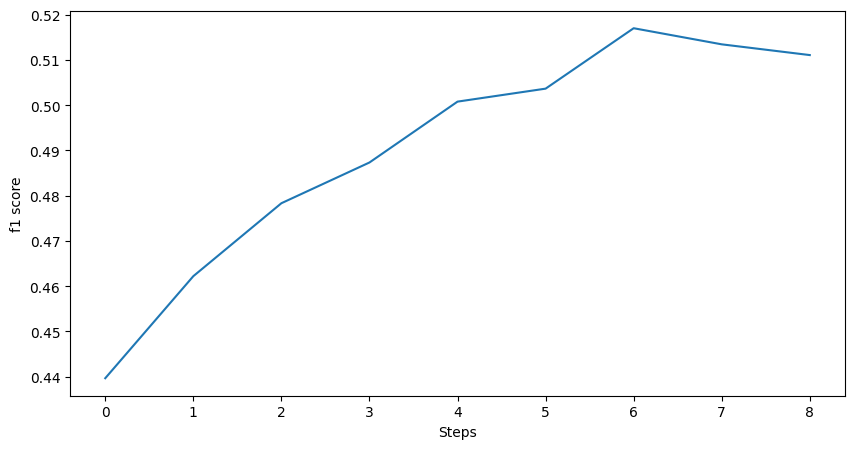

In [19]:
fig2 = plt.figure(figsize=(10, 5))
fig2.add_subplot()
plt.xlabel("Steps")
plt.ylabel("f1 score")
plt.plot(np.arange(len(test_f1)), test_f1)

task.logger.report_matplotlib_figure(title="F1 / Steps",figure=fig2, series="f1")

In [20]:
from sklearn.metrics import classification_report


def custom_classification_report(params, test_loader):
    preds = list()
    actual = list()
    for batch in tqdm(test_loader):
        xs, ys = batch
        pred = test_step(state, xs)
        pred = jnp.argmax(pred, axis=-1).tolist()
        preds.extend(pred)
        actual.extend(ys.tolist())

    clf = classification_report(preds, actual, target_names=classes)
    print(clf)

custom_classification_report(state.params, testloader)
        

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       plane       0.64      0.53      0.58      1212
         car       0.43      0.76      0.55       562
        bird       0.39      0.38      0.39      1009
         cat       0.42      0.36      0.38      1167
        deer       0.38      0.48      0.43       796
         dog       0.37      0.49      0.42       756
        frog       0.72      0.49      0.59      1457
       horse       0.59      0.62      0.61       964
        ship       0.60      0.64      0.62       937
       truck       0.64      0.56      0.60      1140

    accuracy                           0.52     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.54      0.52      0.52     10000



In [21]:
task.close()